In [1]:
import tensorflow as tf
import numpy as np
from nbutil import imshow_multi
import os
from PIL import Image
import urllib, cStringIO
import random

In [2]:
attr_file = '../data/celeba/list_attr_celeba.txt'
keys = None
attributes_by_image = {}
for i, line in enumerate(open(attr_file)):
    if i == 1:
        keys = line.split()
    elif i > 1:
        image = os.path.join('../data/celeba/img_align_celeba', line.split()[0])
        values = line.split()[1:]
        attributes_by_image[image] = {attr: val == '1' for attr, val in zip(keys, values)}

In [3]:
BATCH_SIZE = 8

In [4]:
# filename_queue = tf.train.string_input_producer(image_names, num_epochs=None)
# attr_queue = tf.train.input_producer(tf.constant(attr_vector), num_epochs=None)

def create_qs(image_names):
    filename_tensor = tf.convert_to_tensor(image_names, dtype=tf.string)
    filename_q = tf.train.slice_input_producer([filename_tensor], num_epochs=None, shuffle=True)[0]

    # reader = tf.WholeFileReader()
    # filename, image_data = reader.read(filename_q)
    image_255 = tf.image.decode_jpeg(tf.read_file(filename_q))
    image = tf.reshape(tf.cast(image_255, tf.float32) / 255.0, [218, 178, 3]) # images are 178x218
    image = tf.image.resize_image_with_crop_or_pad(image, 128, 128)

    def distort_image(image):
        noise_amt = tf.abs(tf.pow(tf.random_normal([], stddev=0.1), 2))
        distorted_image = image + tf.random_uniform([128, 128, 3], maxval=noise_amt)
        distorted_image = tf.image.random_flip_left_right(distorted_image)
        distorted_image = tf.image.random_brightness(distorted_image, max_delta=0.3)
        distorted_image = tf.image.random_contrast(distorted_image, lower=0.7, upper=1.3)
        # distorted_image = tf.image.per_image_standardization(distorted_image)
        # distorted_image = tf.clip_by_value(distorted_image, 0, 1)
        return distorted_image

    image = distort_image(image)

    batch = tf.train.shuffle_batch([image], batch_size=BATCH_SIZE, capacity=512, min_after_dequeue=256)
    return tf.image.resize_bilinear(batch, [64, 64])
    # return tf.image.rgb_to_grayscale(tf.image.resize_bilinear(batch, [64, 64]))

batch = create_qs(attributes_by_image.keys())


In [ ]:
session = tf.Session()
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
session.run(init_op)
tf.train.start_queue_runners(sess=session)

[<Thread(Thread-4, started daemon 140515774576384)>,
 <Thread(Thread-5, started daemon 140514979612416)>]

In [ ]:
%matplotlib inline

images_ = session.run(batch)
print images_.shape
imshow_multi(np.tile(images_[:5], [1,1,1,1]))

In [7]:
dropout_keep_prob = tf.placeholder_with_default(tf.constant(1.0), [], name='dropout_keep_prob')        
from tensorflow.contrib.layers.python.layers import batch_norm

def relu_fn(x):
    # leaky relu
    alpha = 0.05
    return tf.maximum(alpha*x,x)

keyed_vars = {}
def join_keys(key1, key2):
    if key1 is None or key2 is None:
        return None
    else:
        return key1 + '.' + key2

def weight_var(shape, stddev=0.1, mean=0.0, weight_decay=0, name=None, key=None):
    initial = tf.truncated_normal(shape, mean=mean, stddev=stddev)
    v = tf.Variable(initial, name=name)
    if weight_decay > 0:
        l2 = tf.nn.l2_loss(v) * weight_decay
        tf.add_to_collection('losses', l2)
    if key: keyed_vars[key] = v
    return v

def create_fc(input, out_size, relu=True, key=None):
    # input_dropped = tf.nn.dropout(input, dropout_keep_prob)
    in_size = input.get_shape()[-1].value
    w = weight_var([in_size, out_size], name='w', key=join_keys(key, 'w'))
    b = weight_var([out_size], mean=0.1, name='b', key=join_keys(key, 'b'))
    x = tf.matmul(input, w)
    return relu_fn(x + b) if relu else x + b

def create_conv(input, out_channels, patch_size=5, stride=1, dropout=False, key=None, use_relu=True):
    in_channels = input.get_shape()[-1].value
    w = weight_var([patch_size, patch_size, in_channels, out_channels], name='w', key=join_keys(key, 'w'))
    b = weight_var([out_channels], stddev=0, name='b', mean=0.1, key=join_keys(key, 'b'))
    conv = tf.nn.conv2d(input, w, strides=[1,stride,stride,1], padding='SAME')
    activation = relu_fn(conv + b) if use_relu else conv + b
    if dropout: activation = create_dropout(activation)
    return activation

def create_deconv(input, out_channels, patch_size=5, stride=1, use_relu=True):
    # for best results, patch_size should be a multiple of stride
    input_w, input_h, input_channels = [i.value for i in input.get_shape()[-3:]]
    
    w = weight_var([patch_size, patch_size, out_channels, input_channels])
    b = weight_var([out_channels], mean=0.1)
    
    batch_size = BATCH_SIZE # tf.shape(input)[0]
    output_shape = tf.pack([batch_size, input_w*stride, input_h*stride, out_channels])
    
    deconv = tf.nn.conv2d_transpose(input, w, output_shape, strides=[1,stride,stride,1], padding='SAME')
    
    activation = relu_fn(deconv + b) if use_relu else deconv + b
    return activation

def create_max_pool(inputs, ksize=2, stride=2):
    return tf.nn.max_pool(inputs, ksize=[1, ksize, ksize, 1], strides=[1, stride, stride, 1], padding='SAME')

def create_avg_pool(inputs, ksize=2, stride=2):
    return tf.nn.avg_pool(inputs, ksize=[1, ksize, ksize, 1], strides=[1, stride, stride, 1], padding='SAME')

def create_batch_norm(inputs):
    return batch_norm(inputs, is_training=True, updates_collections=None)

def create_dropout(inputs):
    return tf.nn.dropout(inputs, dropout_keep_prob)

def flatten_tensor(t):
    shape = [s.value for s in t.get_shape()]
    flat_size = 1
    for x in shape[1:]:
        flat_size *= x
    return tf.reshape(t, [-1, flat_size])

In [8]:
def generator(noise, name='generator'):
    with tf.variable_scope(name):
        image = create_fc(noise, 512)
        image = tf.reshape(image, [-1, 4, 4, 32])
        for size, stride, channels in [(4, 2, 32), (4, 2, 32), (4, 2, 32), (4, 2, 16)]:
            image = create_deconv(image, channels, size, stride)
            # image = create_batch_norm(image)
        image = create_conv(image, 3, 1, 1, use_relu=False)
        return image

def critic(image, name='critic', reuse=False):
    with tf.variable_scope(name, reuse=reuse):
        for x in [16, 32, 64]:
            image = create_conv(image, x, patch_size=5)
            image = create_avg_pool(image)
        image = flatten_tensor(image)
        # image = create_dropout(image)
        image = create_fc(image, 256)
        return create_fc(image, 2)

noise = tf.placeholder_with_default(tf.random_normal([BATCH_SIZE, 128]), [BATCH_SIZE, 128], name='noise')
generated = generator(noise)

real = batch
critic_output = critic(tf.concat(0, [real, generated]))
are_reals_real = critic_output[:BATCH_SIZE]
are_fakes_real = critic_output[BATCH_SIZE:]

critic_loss = -tf.reduce_mean(are_fakes_real)
gen_loss = tf.reduce_mean(are_fakes_real) - tf.reduce_mean(are_reals_real) # minimize are_fakes_real, maximize are_reals_real

global_step = tf.contrib.framework.get_or_create_global_step()

gen_lr = tf.placeholder_with_default(tf.constant(5e-5), [], 'gen_lr')
critic_lr = tf.placeholder_with_default(tf.constant(5e-5), [], 'critic_lr')

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')
train_gen = tf.train.RMSPropOptimizer(gen_lr).minimize(gen_loss, global_step=global_step, var_list=gen_vars)

critic_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='critic')
weight_clip_op = tf.group(*[w.assign(tf.clip_by_value(w, -0.01, 0.01)) for w in critic_vars])
train_critic_op = tf.train.RMSPropOptimizer(critic_lr).minimize(critic_loss, global_step=global_step, var_list=critic_vars)
train_critic = tf.group(train_critic_op, weight_clip_op)


In [9]:
save_path = None # 'models/facegan-2.3'

init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
session.run(init_op)

saver = None
if save_path:
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(save_path)
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(session, ckpt.model_checkpoint_path)
        print 'Restored from checkpoint', ckpt.model_checkpoint_path
    else:
        print 'Did not restore from checkpoint'
else:
    print 'Will not save progress'

Will not save progress


Step: 10, critic loss: -0.00535008916631


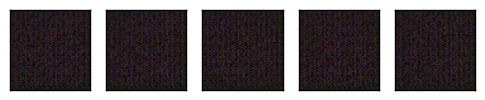

Step: 13, critic loss: -0.00550073292106


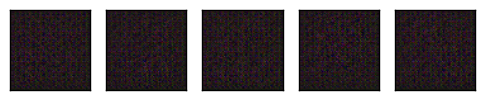

Step: 16, critic loss: -0.00580621790141


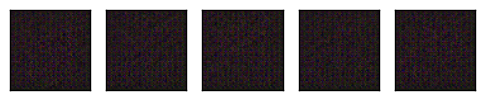

Step: 19, critic loss: -0.00634848512709


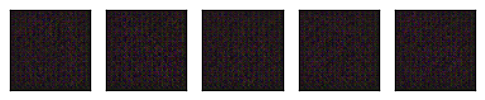

Step: 22, critic loss: -0.00714645115659


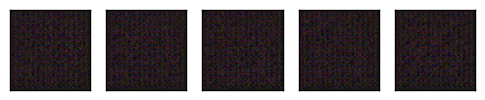

Step: 25, critic loss: -0.00817928928882


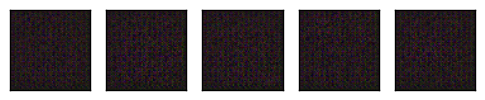

Step: 28, critic loss: -0.0095296446234


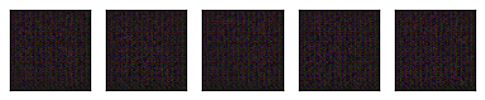

Step: 31, critic loss: -0.0115747805685


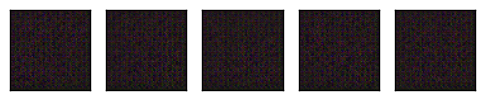

Step: 34, critic loss: -0.0155855147168


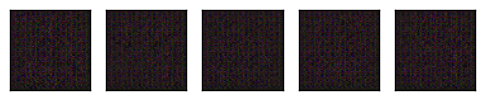

Step: 37, critic loss: -0.0353623256087


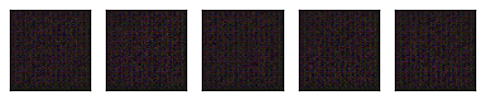

Step: 40, critic loss: -0.0918938145041


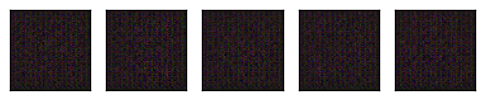

Step: 43, critic loss: -0.234516620636


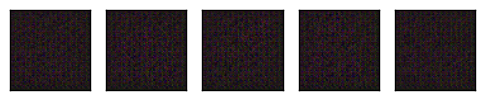

Step: 46, critic loss: -0.514727532864


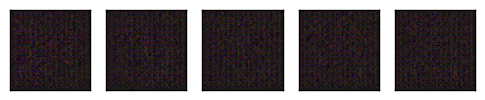

Step: 49, critic loss: -0.9906001091


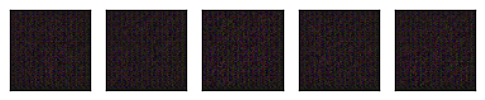

Step: 52, critic loss: -1.72296690941


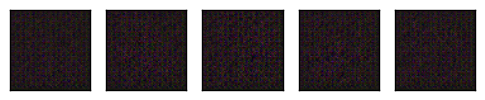

Step: 55, critic loss: -2.76604413986


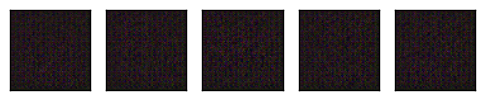

Step: 58, critic loss: -4.17048740387


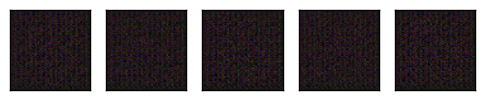

Step: 61, critic loss: -5.96675395966


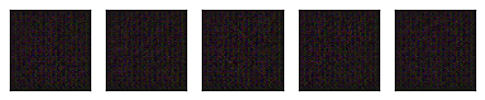

Step: 64, critic loss: -8.1765203476


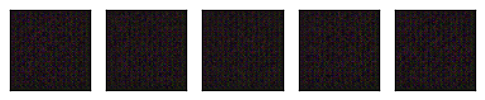

Step: 67, critic loss: -10.8042430878


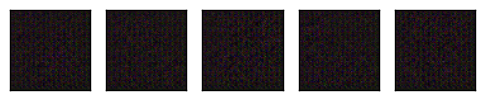

Step: 70, critic loss: -13.8344669342


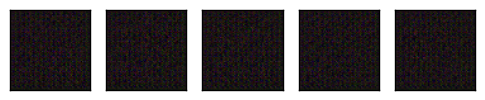

Step: 73, critic loss: -17.0623760223


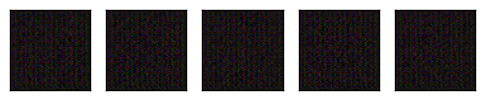

Step: 76, critic loss: -20.710477829


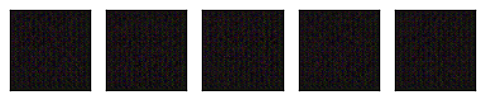

Step: 79, critic loss: -24.4848937988


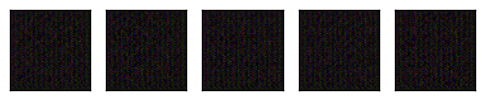

Step: 82, critic loss: -28.3227844238


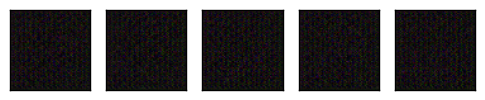

Step: 85, critic loss: -31.6394519806


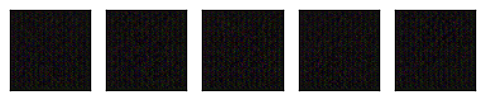

Step: 88, critic loss: -34.6591415405


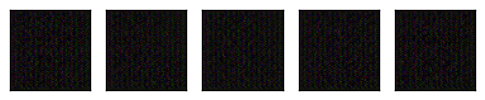

Step: 91, critic loss: -37.0358200073


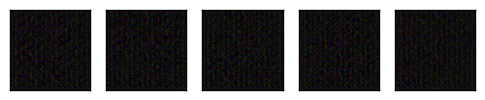

Step: 94, critic loss: -39.1147155762


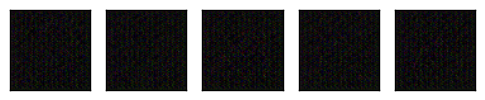

Step: 97, critic loss: -38.877571106


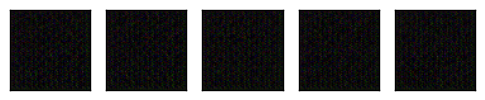

Step: 100, critic loss: -36.0875244141


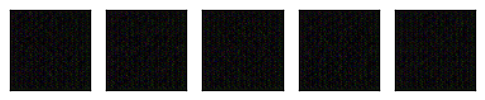

Step: 103, critic loss: -32.4278793335


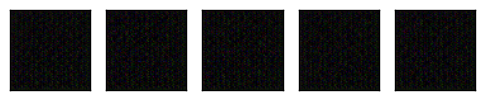

Step: 106, critic loss: -27.9140663147


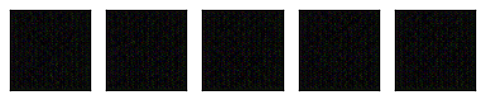

Step: 109, critic loss: -23.5636062622


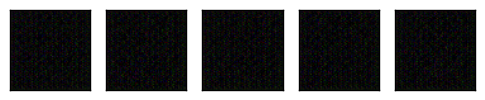

Step: 112, critic loss: -17.4523429871


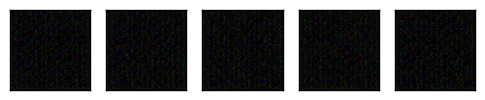

Step: 115, critic loss: -16.622297287


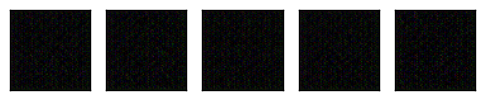

Step: 118, critic loss: -13.4156742096


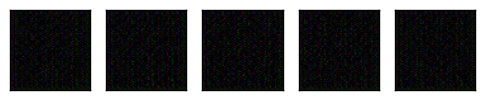

Step: 121, critic loss: -11.8513126373


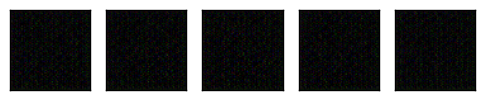

Step: 124, critic loss: -11.3791246414


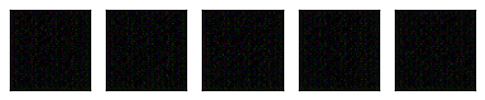

Step: 127, critic loss: -10.439248085


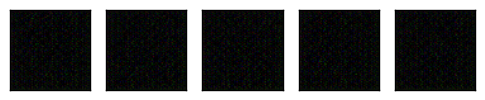

Step: 130, critic loss: -10.6922035217


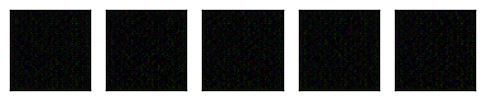

Step: 133, critic loss: -9.72545337677


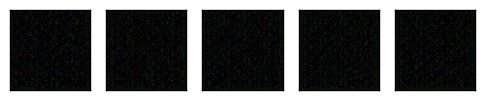

Step: 136, critic loss: -9.77802085876


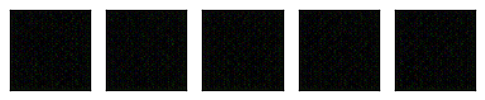

Step: 139, critic loss: -10.1396198273


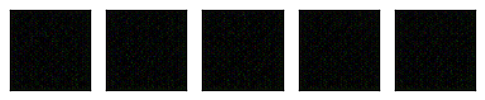

Step: 142, critic loss: -10.0336589813


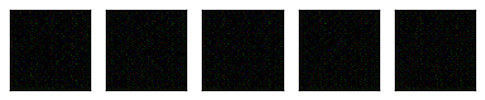

Step: 145, critic loss: -11.3111534119


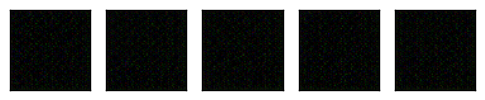

Step: 148, critic loss: -11.6874675751


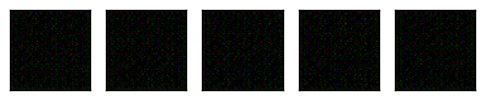

Step: 151, critic loss: -12.8920621872


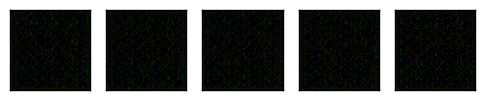

Step: 154, critic loss: -14.2810325623


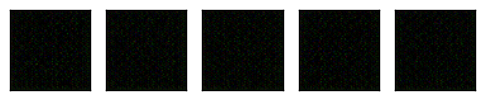

Step: 157, critic loss: -16.367099762


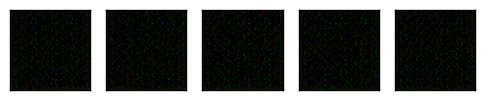

Step: 160, critic loss: -19.3927230835


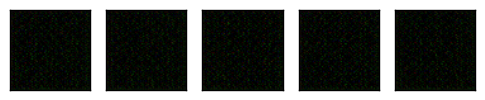

Step: 163, critic loss: -22.9077167511


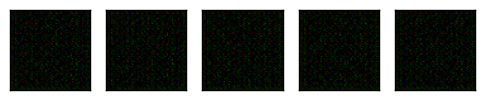

Step: 166, critic loss: -26.0323829651


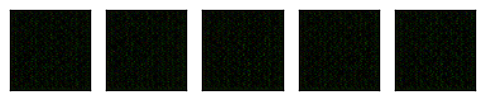

Step: 169, critic loss: -26.9476242065


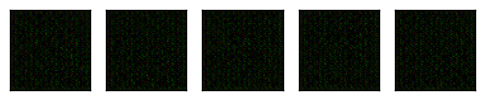

Step: 172, critic loss: -28.4599781036


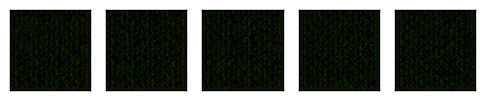

Step: 175, critic loss: -29.6010551453


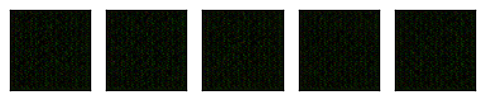

Step: 178, critic loss: -29.7410011292


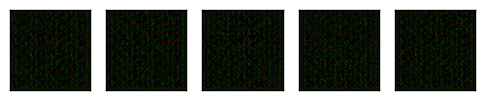

Step: 181, critic loss: -28.6529846191


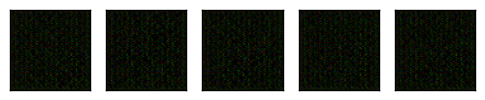

Step: 184, critic loss: -28.205783844


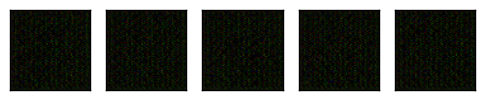

Step: 187, critic loss: -25.9940624237


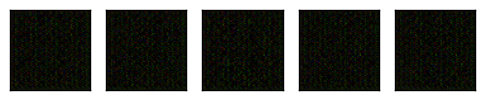

Step: 190, critic loss: -24.3789100647


KeyboardInterrupt: 

In [11]:
%matplotlib inline

while True:
    feed = {}
    for _ in range(5):
        session.run(train_critic, feed_dict=feed)
    _, critic_loss_, step_ = session.run([train_gen, critic_loss, global_step], feed_dict=feed)
    step_ = step_ / 6
    
    if step_ % 3 == 1:
        print 'Step: {}, critic loss: {}'.format(step_, critic_loss_)
        imgs_ = session.run(generated[:5])
        imshow_multi(np.tile(imgs_, [1,1,1,1]))
    
    if step_ % 700 == 0 and saver:
        saver.save(session, save_path + '/model.ckpt', global_step=step_)
        print 'Saved'
        

In [ ]:
%matplotlib inline
import moviepy.editor as mpy

face_vecs = [np.random.normal(size=128) for _ in xrange(10)]
face_vecs.append(face_vecs[0])

interpolated = []
for v1, v2 in zip(face_vecs[:-1], face_vecs[1:]):
    def blend(x): return v1 * (1-x) + v2 * x
    interpolated += [blend(i/32.0) for i in xrange(32)]


faces = []
for offset in xrange(len(interpolated) / BATCH_SIZE + 1):
    batch = interpolated[offset * BATCH_SIZE: min(len(interpolated), (offset+1) * BATCH_SIZE)]
    size = len(batch)
    while len(batch) < BATCH_SIZE: 
        batch.append(interpolated[-1])
    faces += list(session.run(generated, feed_dict={noise: batch})[:size])

# imshow_multi(faces[:10])
def to_pil(img):
    return Image.fromarray(np.clip(img * 255, 0, 255).astype(np.uint8))

fps = 15

def make_frame(t):
    face = faces[int(t * fps)]
    return np.clip(face * 255, 0, 255).astype(np.uint8)

clip = mpy.VideoClip(make_frame, duration=len(faces) / float(fps))
clip.write_gif('ani.gif', fps=15)
